2023-12-05 00:10:15.825863: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/164
28/28 - 25s - loss: 0.0892 - val_loss: 0.0211 - 25s/epoch - 888ms/step
Epoch 2/164
28/28 - 0s - loss: 0.1329 - val_loss: 0.2367 - 497ms/epoch - 18ms/step
Epoch 3/164
28/28 - 1s - loss: 0.0656 - val_loss: 0.0836 - 502ms/epoch - 18ms/step
Epoch 4/164
28/28 - 0s - loss: 0.0053 - val_loss: 0.0872 - 409ms/epoch - 15ms/step
Epoch 5/164
28/28 - 0s - loss: 0.0041 - val_loss: 0.0626 - 376ms/epoch - 13ms/step
Epoch 6/164
28/28 - 0s - loss: 0.0015 - val_loss: 0.0459 - 470ms/epoch - 17ms/step
Epoch 7/164
28/28 - 1s - loss: 3.5995e-04 - val_loss: 0.0359 - 572ms/epoch - 20ms/step
Epoch 8/164
28/28 - 0s - loss: 4.0167e-04 - val_loss: 0.0334 - 458ms/epoch - 16ms/step
Epoch 9/164
28/28 - 0s - loss: 4.6135e-04 - val_loss: 0.0354 - 492ms/epoch - 18ms/step
Epoch 10/164
28/28 - 1s - loss: 3.2566e-04 - val_loss: 0.0365 - 533ms/epoch - 19ms/step
Epoch 11/164
28/28 - 1s - loss: 2.4410e-04 - val_loss: 0.0363 - 504ms/epoch - 18ms/step
Epoch 12/164
28/28 - 0s - loss: 2.2051e-04 - val_loss: 0.0344 - 4

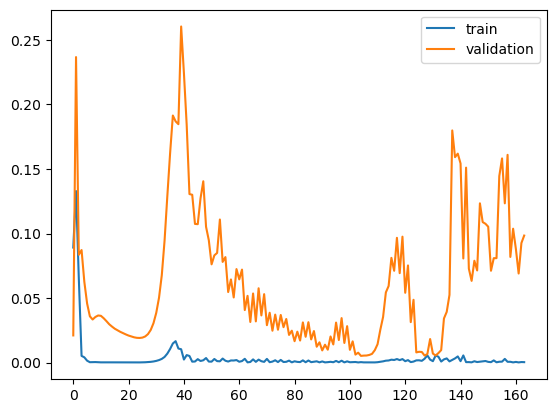

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 128)            55680     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 95041 (371.25 KB)
Trainable params: 95041 (371.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


/Users/kendrickwinata/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.31374534608676463


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Embedding, TimeDistributed, LeakyReLU
from tensorflow.keras.layers import GRU, LSTM
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot
from pickle import load

# Load data
X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)
yc_train = np.load("yc_train.npy", allow_pickle=True)
yc_test = np.load("yc_test.npy", allow_pickle=True)

# Parameters
LR = 0.0001
BATCH_SIZE = 128
N_EPOCH = 164

input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]


def basic_GRU(input_dim, output_dim, feature_size) -> tf.keras.models.Model:
    model = Sequential()
    model.add(GRU(units=128, return_sequences = True, input_shape=(input_dim, feature_size)))  # 256, return_sequences = True
    # model.add(GRU(units=256, recurrent_dropout = 0.2)) #, return_sequences = True
    model.add(GRU(units=64, input_shape=(input_dim, feature_size)))
    #model.add(Dense(128))
    model.add(Dense(32))
    # model.add(Dense(32))
    model.add(Dense(units=output_dim))
    model.compile(optimizer=Adam(lr=LR), loss='mse')
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                        verbose=2, shuffle=False)

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    return model


model = basic_GRU(input_dim, output_dim, feature_size)
print(model.summary())
model.save('GRU_30to3.h5')

yhat = model.predict(X_test, verbose=0)
# print(yhat)

rmse = sqrt(mean_squared_error(y_test, yhat))
print(rmse)

In [2]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error, mean_absolute_percentage_error
# %% --------------------------------------- Plot the result  -----------------------------------------------------------------
## TRAIN DATA
def plot_traindataset_result(X_train, y_train):
    train_yhat = model.predict(X_train, verbose=0)

    y_scaler = load(open('y_scaler.pkl', 'rb'))
    train_predict_index = np.load("index_train.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_train)
    rescaled_predicted_y = y_scaler.inverse_transform(train_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=train_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=train_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Train", fontsize=20)
    plt.show()

   # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Test RMSE -- ', RMSE)

    # Calculate MAE
    MAE = mean_absolute_error(real, predicted)
    print('-- MAE -- ', MAE)

    # Calculate R2
    R2 = r2_score(real, predicted)
    print('-- R2 -- ', R2)

    # Calculate MSLE
    MSLE = mean_squared_log_error(real, predicted)
    print('-- MSLE -- ', MSLE)

    # Calculate MAPE
    MAPE = mean_absolute_percentage_error(real, predicted)
    print('-- MAPE -- ', MAPE)

    return predict_result, RMSE, MAE, R2, MSLE, MAPE
    
train_predicted, train_RMSE, train_MAE, train_R2, train_MSLE, train_MAPE  = plot_traindataset_result(X_train, y_train)

            predicted_price  predicted_price  predicted_price  \
2022-12-16              NaN              NaN              NaN   
2022-12-19              NaN              NaN              NaN   
2022-12-20              NaN              NaN              NaN   
2022-12-21              NaN              NaN              NaN   
2022-12-22              NaN              NaN              NaN   
2022-12-23              NaN              NaN              NaN   
2022-12-27              NaN              NaN              NaN   
2022-12-28              NaN              NaN              NaN   
2022-12-29              NaN              NaN              NaN   
2022-12-30              NaN              NaN              NaN   

            predicted_price  predicted_price  predicted_price  \
2022-12-16              NaN              NaN              NaN   
2022-12-19              NaN              NaN              NaN   
2022-12-20              NaN              NaN              NaN   
2022-12-21              

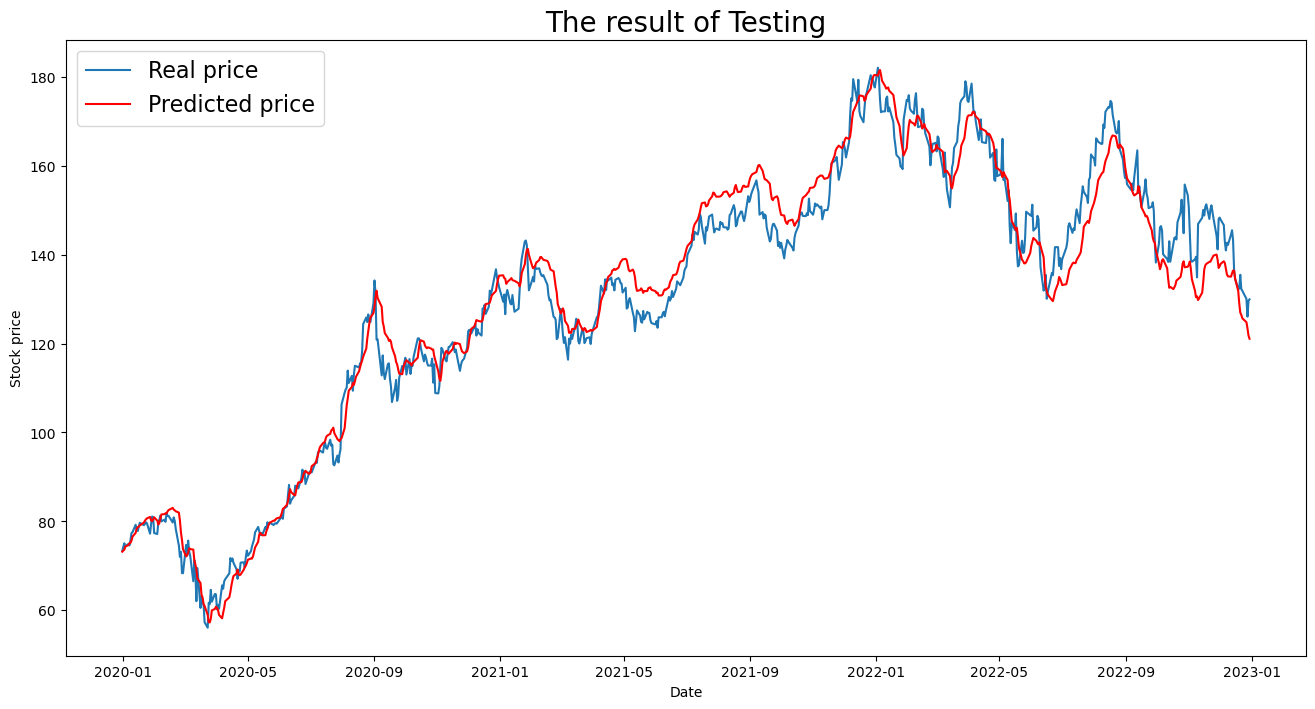

-- Train RMSE --  5.560399401016762
-- MAE --  4.384311630309977
-- R2 --  0.9671825770361898
-- MSLE --  0.0017515967652569975
-- MAPE --  0.03353558351758441
----- Test_RMSE_GRU ----- 5.560399401016762


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error, mean_absolute_percentage_error

# %% --------------------------------------- Plot the result  -----------------------------------------------------------------
def plot_testdataset_result(X_test, y_test):

    test_yhat = model.predict(X_test, verbose=0)
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = np.load("index_test.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    print(predict_result.tail(10))

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)

     # Calculate MAE
    MAE = mean_absolute_error(real, predicted)
    print('-- MAE -- ', MAE)

    # Calculate R2
    R2 = r2_score(real, predicted)
    print('-- R2 -- ', R2)

    # Calculate MSLE
    MSLE = mean_squared_log_error(real, predicted)
    print('-- MSLE -- ', MSLE)

    # Calculate MAPE
    MAPE = mean_absolute_percentage_error(real, predicted)
    print('-- MAPE -- ', MAPE)

    return predict_result, RMSE, MAE, R2, MSLE, MAPE


test_predicted, test_RMSE, test_MAE, test_R2, test_MSLE, test_MAPE  = plot_testdataset_result(X_test, y_test)
print("----- Test_RMSE_GRU -----", test_RMSE)
